# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

In [5]:
%cuda_context_handler gpu_ctx_refined2

## Setting-up case 

In [6]:
nx = 1000
ny = 1000

dx = 1000
dy = 1000

dt = 0.0
g = 9.81
f = 1.2e-4
r = 0.0
H0 = 1000.0

bc = Common.BoundaryConditions(3,3,3,3, spongeCells={"north":10, "south":10, "east":10, "west":10})


In [7]:
dataShape = (ny + 4, nx + 4)

In [8]:
eta0  = np.zeros(dataShape, dtype=np.float32, order='C')
hu0   = np.zeros(dataShape, dtype=np.float32, order='C');
hv0   = np.zeros(dataShape, dtype=np.float32, order='C');

Hi = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)


In [9]:
x_center = dx*nx*0.5
y_center = dy*ny*0.5

size = 1e9
for j in range(-2, ny + 2):
    for i in range(-2, nx + 2):
        x = dx*i - x_center
        y = dy*j - y_center
        
        if (np.sqrt(x**2 + y**2) < size):
            eta0[j+2, i+2] += 1.0*np.exp(-(x**2+y**2)/size)

In [10]:
size/dx

1000000.0

Text(0.5, 1.0, 'Init eta')

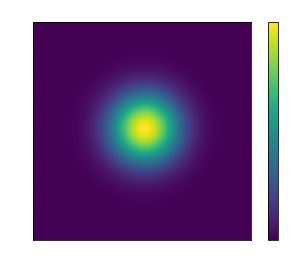

In [11]:
plt.imshow(eta0[400:600,400:600], vmin=0.0)
plt.colorbar()
plt.title("Init eta")

Mass Check

In [12]:
N = 100
sub_t = 25

## One-Res Simulation

In [13]:
from gpuocean.SWEsimulators import CDKLM16

sim1 = CDKLM16.CDKLM16(gpu_ctx,
                            eta0, hu0, hv0, \
                            Hi, \
                            nx, ny, \
                            dx, dy, dt, \
                            g, f, r, \
                            boundary_conditions=bc, \
                            write_netcdf=False)

In [14]:
mass1 = np.zeros(N)

for n in range(N):
    mass1[n] = np.sum(sim1.download(interior_domain_only=True)[0])
    sim1.step(sub_t)

## Multi-Res Simulation

Defining local area

In [26]:
# [[y0,x0],[y1,x1]]
loc = [[250, 250], [750,750]]

scale = 2.0

In [27]:
sim2 = CDKLM16.CDKLM16(gpu_ctx,
                            eta0, hu0, hv0, \
                            Hi, \
                            nx, ny, \
                            dx, dy, dt, \
                            g, f, r, \
                            boundary_conditions=bc, \
                            write_netcdf=False)
sim2.give_birth(gpu_ctx_refined, loc, scale)

The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [28]:
mass2 = np.zeros(N)

for n in range(N):
    mass2[n] = np.sum(sim2.download(interior_domain_only=True)[0])
    sim2.step(sub_t)

### Three-Res Sim

In [29]:
sim3 = CDKLM16.CDKLM16(gpu_ctx,
                            eta0, hu0, hv0, \
                            Hi, \
                            nx, ny, \
                            dx, dy, dt, \
                            g, f, r, \
                            boundary_conditions=bc, \
                            write_netcdf=False)
sim3.give_birth(gpu_ctx_refined, loc, scale)
sim3.children[0].give_birth(gpu_ctx_refined2, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.
The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [30]:
mass3 = np.zeros(N)

for n in range(N):
    mass3[n] = np.sum(sim3.download(interior_domain_only=True)[0])
    sim3.step(sub_t)

Mass

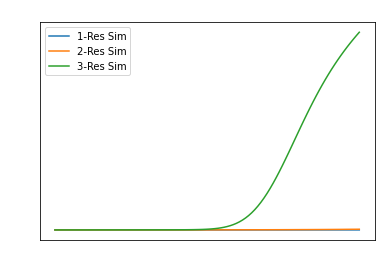

In [31]:
ts = np.arange(N)*sub_t/(12*60)
plt.plot(ts, mass1, label="1-Res Sim")
plt.plot(ts, mass2, label="2-Res Sim")
plt.plot(ts, mass3, label="3-Res Sim")
plt.title("Mass in system")
plt.xlabel("Time [h]")
plt.legend(labelcolor="black")

In [33]:
print("The mass deficiency co-incides with border crossing of the wave!!!")

Check whether mass loss co-incides with border crossing of the wave!!!


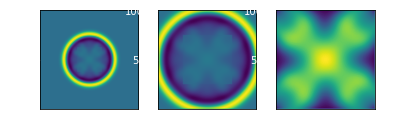

In [32]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(sim3.download()[0])
axs[1].imshow(sim3.children[0].download()[0])
axs[2].imshow(sim3.children[0].children[0].download()[0])